Topic Modeling

In [80]:
# import the dataset

import pandas as pd

df = pd.read_csv('bbc-news-data.csv', sep='\t')

In [81]:
# list columns

print(df.columns)

Index(['category', 'filename', 'title', 'content'], dtype='object')


In [82]:
# introduce a preprocessed column of 'content'

df['prep content'] = df['content']

In [83]:
print(df.head(10))

   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   
5  business  006.txt   Japan narrowly escapes recession   
6  business  007.txt   Jobs growth still slow in the US   
7  business  008.txt   India calls for fair trade rules   
8  business  009.txt  Ethiopia's crop production up 24%   
9  business  010.txt  Court rejects $280bn tobacco case   

                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   
5   Japan's ec

In [60]:
# preprocess the dataset

import spacy
from tqdm import tqdm

tqdm.pandas()

nlp = spacy.load('en_core_web_lg')

def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

df['prep content'] = df['prep content'].progress_apply(preprocess)
print("'Content' preprocessed!")

100%|██████████| 2225/2225 [02:25<00:00, 15.27it/s]

'Content' preprocessed!


In [84]:
# drop duplicates

df = df.drop_duplicates(subset=['content'])

In [85]:
# drop columns with empty, NaN/,NaT, null and "" columns

df.replace("", pd.NA, inplace=True)
df.dropna(inplace=True)

In [64]:
# generate and download the preprocessed dataset (just in case)

df.to_csv("preprocessed_bbc-news-data.csv", index=False)

from google.colab import files
files.download("preprocessed_bbc-news-data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# continuation

import pandas as pd

df = pd.read_csv('preprocessed_bbc-news-data.csv')

In [3]:
print(df.head(10))

   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   
5  business  006.txt   Japan narrowly escapes recession   
6  business  007.txt   Jobs growth still slow in the US   
7  business  008.txt   India calls for fair trade rules   
8  business  009.txt  Ethiopia's crop production up 24%   
9  business  010.txt  Court rejects $280bn tobacco case   

                                             content  \
0   Quarterly profits at US media giant TimeWarne...   
1   The dollar has hit its highest level against ...   
2   The owners of embattled Russian oil giant Yuk...   
3   British Airways has blamed high fuel prices f...   
4   Shares in UK drinks and food firm Allied Dome...   
5   Japan's ec

In [74]:
# tf-idf vectorization both models

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_lda = TfidfVectorizer(max_df=0.2, min_df=10, stop_words='english')
X_lda = vectorizer_lda.fit_transform(df['prep content'])

vectorizer_nmf = TfidfVectorizer(max_df=0.2, min_df=10, stop_words='english')
X_nmf = vectorizer_nmf.fit_transform(df['prep content'])

In [77]:
# training both models

from sklearn.decomposition import LatentDirichletAllocation, NMF

lda_model = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    max_iter=10
)

W_lda = lda_model.fit_transform(X_lda)

nmf_model = NMF(
    n_components=5,
    random_state=42,
    max_iter=10
)

W_nmf = nmf_model.fit_transform(X_nmf)

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [78]:
# bonus: comparing lda vs. nmf performances

from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

lda_doc_topic = normalize(W_lda)
nmf_doc_topic = normalize(W_nmf)

nmf_labels = nmf_doc_topic.argmax(axis=1)
lda_labels = lda_doc_topic.argmax(axis=1)

print("LDA Silhouette Score:", silhouette_score(lda_doc_topic, lda_labels))
print("NMF Silhouette Score:", silhouette_score(nmf_doc_topic, nmf_labels))

LDA Silhouette Score: 0.7629328091639809
NMF Silhouette Score: 0.6735065356369976


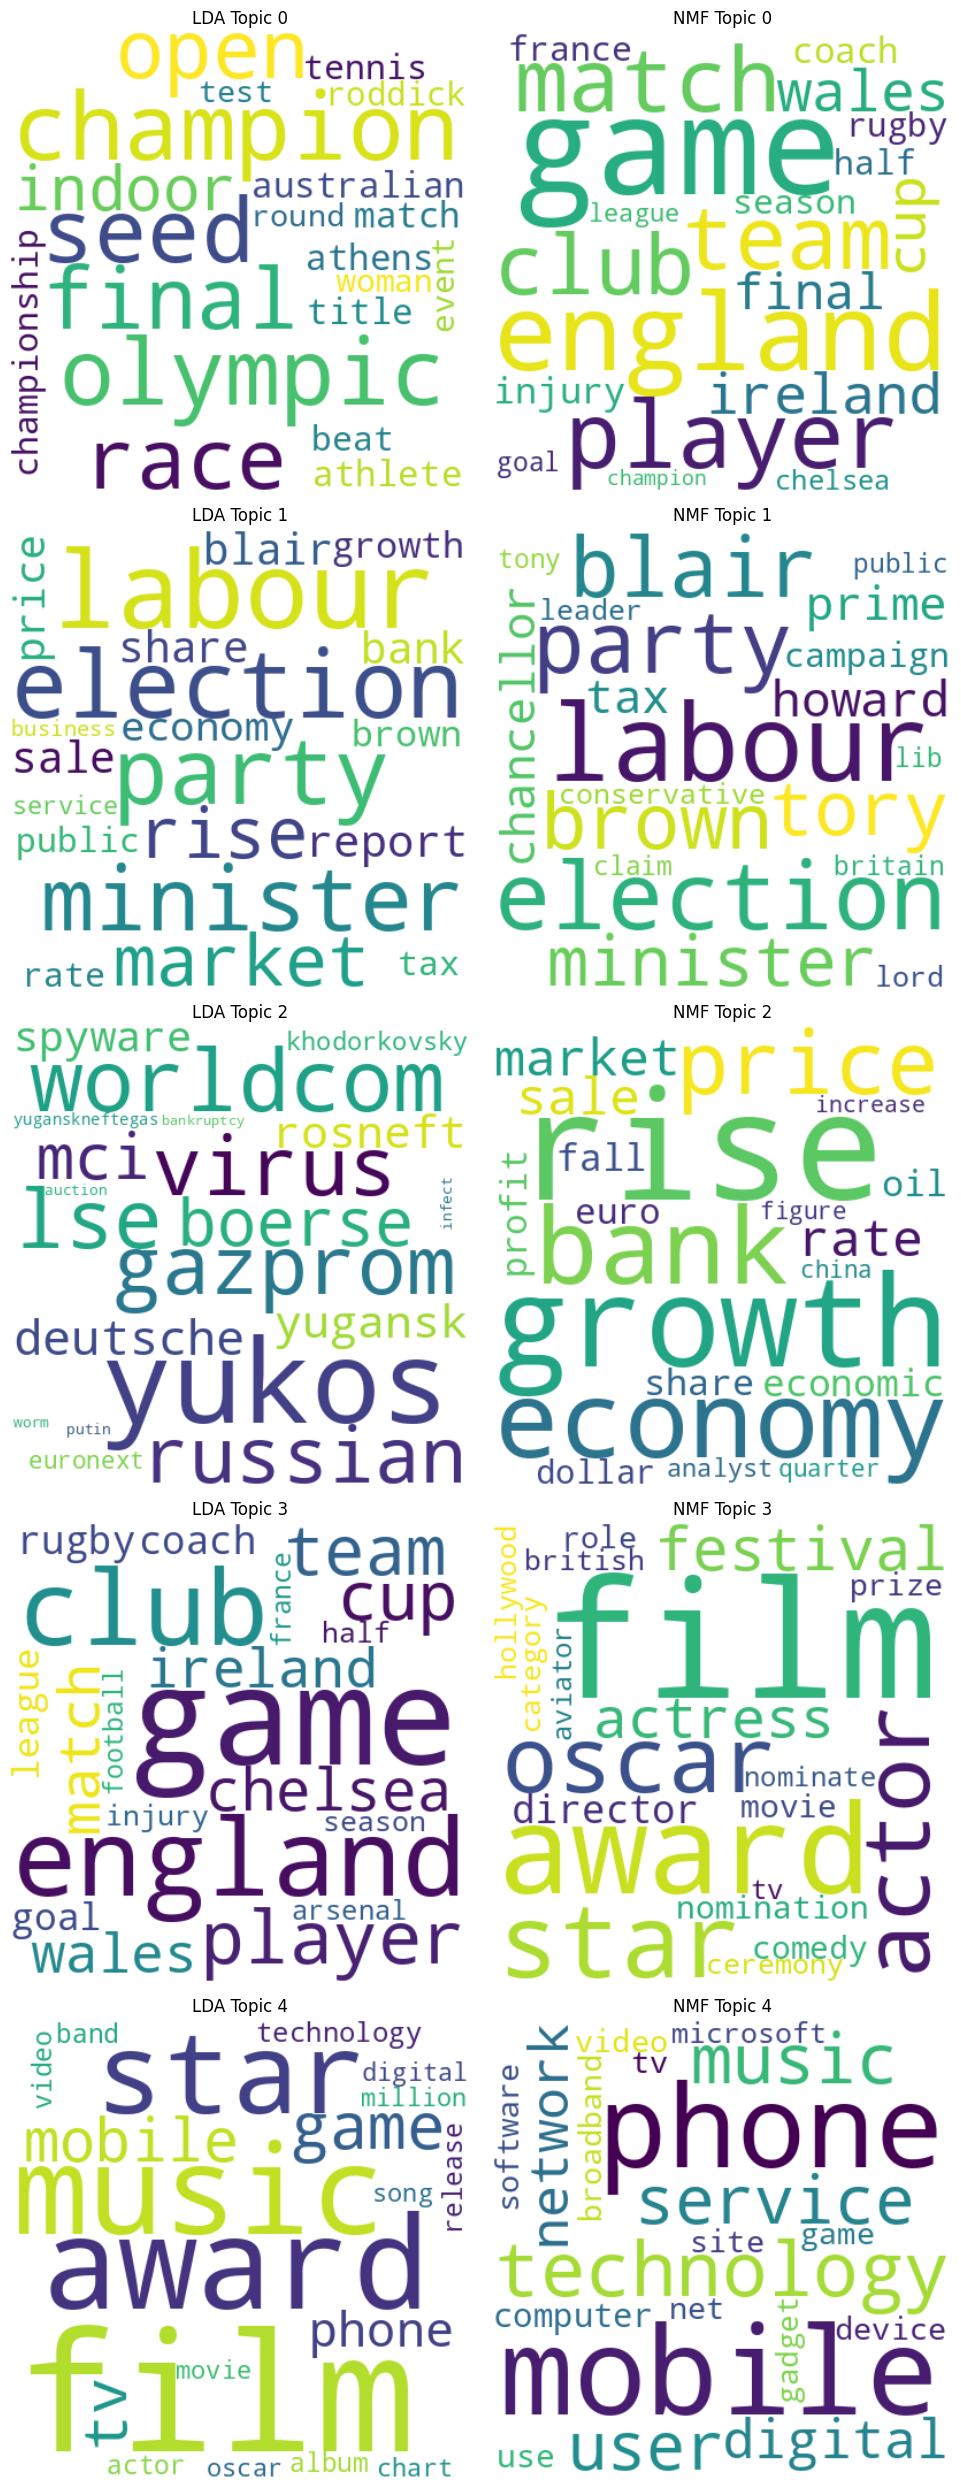

In [79]:
# bonus: visualizing topic-word distributions

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud(topic_words):
    word_freq = {word: weight for word, weight in topic_words}
    return WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)

feature_names_lda = vectorizer_lda.get_feature_names_out()
feature_names_nmf = vectorizer_nmf.get_feature_names_out()
n_top_words = 20
num_topics = lda_model.components_.shape[0]

plt.figure(figsize=(10, num_topics * 5))

for topic_idx in range(num_topics):
    topic_words_lda = [(feature_names_lda[i], lda_model.components_[topic_idx][i])
                       for i in lda_model.components_[topic_idx].argsort()[:-n_top_words - 1:-1]]
    wc_lda = generate_wordcloud(topic_words_lda)

    plt.subplot(num_topics, 2, topic_idx * 2 + 1)
    plt.imshow(wc_lda, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"LDA Topic {topic_idx}")

    topic_words_nmf = [(feature_names_nmf[i], nmf_model.components_[topic_idx][i])
                       for i in nmf_model.components_[topic_idx].argsort()[:-n_top_words - 1:-1]]
    wc_nmf = generate_wordcloud(topic_words_nmf)

    plt.subplot(num_topics, 2, topic_idx * 2 + 2)
    plt.imshow(wc_nmf, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"NMF Topic {topic_idx}")

plt.tight_layout()
plt.show()